In [1]:
import geopandas as gpd
import pandas as pd
import folium
import shapely
import h3
from shapely import Polygon, Point
import seaborn as sns
import matplotlib.pyplot as plt
from folium.plugins import MarkerCluster
from folium.plugins import HeatMap

In [2]:
gdf_samara_bounds = gpd.read_file(r'Samara_bounds.geojson')

In [3]:
#Чистим датасет от лишних атрибутов
gdf_samara_bounds = gdf_samara_bounds[['name', 'geometry']]

In [4]:
#При рассмотрении видим, что при выкачке скачались не только полигоны, но и линии с точками, уберем их
gdf_samara_bounds= gdf_samara_bounds[gdf_samara_bounds['geometry'].geom_type != 'LineString']
gdf_samara_bounds= gdf_samara_bounds[gdf_samara_bounds['geometry'].geom_type != 'Point']

In [5]:
#Приступаем ко 2-му датасету
df_coffee = pd.read_csv('coffee.csv')

In [6]:
#Так как изначально он имеет формат csv и содержит только столбцы Широта и Долгота, необходимо создать поле geometry
df_coffee['geometry'] = df_coffee[['Широта', 'Долгота']].apply (
    lambda x: Point(x['Долгота'], x['Широта']), axis=1
)

In [7]:
#Переводим в геодатафрейм и устанавливаем геометрию
gdf_coffee = gpd.GeoDataFrame(df_coffee).set_geometry('geometry')

In [8]:
#Задаем общую проекцию
gdf_coffee = gdf_coffee.set_crs('epsg:4326')

In [9]:
#Убираем те кофейни, которые вне границ Самары
gdf_coffee = gpd.sjoin(gdf_coffee, gdf_samara_bounds, how='inner', predicate='within')

In [10]:
gdf_coffee = gdf_coffee[['Наименование', 'Описание', 'Адрес', 'Район', 'Широта', 'Долгота', 'geometry']]

In [11]:
#Удаляем строки с NaN
gdf_coffee = gdf_coffee.dropna(subset=['Широта', 'Долгота'])

In [12]:
#Теперь приступаем к формированию h3 сетки
city_borders = list(gdf_samara_bounds.unary_union.exterior.coords)
polygon = h3.LatLngPoly(city_borders)

C:\Users\acer\AppData\Local\Temp\ipykernel_10992\376629419.py:2: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  city_borders = list(gdf_samara_bounds.unary_union.exterior.coords)


In [13]:
hexs = h3.h3shape_to_cells(polygon, res=8)

In [14]:
polygonise = lambda hex_id: Polygon(h3.cell_to_boundary(hex_id))

In [15]:
#Трансформирует в геодатафрейм
gdf_hex = gpd.GeoDataFrame(list(map(polygonise,hexs)), \
                          index=list(hexs), \
                          crs="EPSG:4326",
                          columns=["geometry"],
                          geometry ="geometry")

In [16]:
gdf_hex.explore()

In [17]:
#Делаем пространственную сцепку с геодатафреймом кофеен
gdf_coffee_hex = gpd.sjoin (
    gdf_hex, gdf_coffee,
     how = 'left', predicate='intersects'
)
gdf_coffee_hex = gdf_coffee_hex.reset_index()
gdf_coffee_hex = gdf_coffee_hex.rename(columns = {'index': 'hex_id'})

In [18]:
gdf_hex = gdf_hex.reset_index()
gdf_hex = gdf_hex.rename(columns={'index': 'hex_id'})

In [19]:
#Считаем, сколько кофеен в каждом гексагоне и сразу создаём из него датафрейм
gdf_coffee_hex_count = pd.DataFrame(gdf_coffee_hex.groupby('hex_id')['index_right'].nunique())

In [20]:
#Соединяем с геодатафреймом гексагонов
gdf_coffee_hex_fin = gdf_coffee_hex_count.merge(gdf_hex, on='hex_id', how='inner')

In [21]:
gdf_coffee_hex_fin = gpd.GeoDataFrame(gdf_coffee_hex_fin.rename(columns={'index_right': 'coffee_count'}))

In [22]:
#Чтобы нам не мозолили глаза гексы, в которых нет ни одной кофейни, убираем их
gdf_coffee_hex_fin = gdf_coffee_hex_fin[gdf_coffee_hex_fin['coffee_count'] != 0]

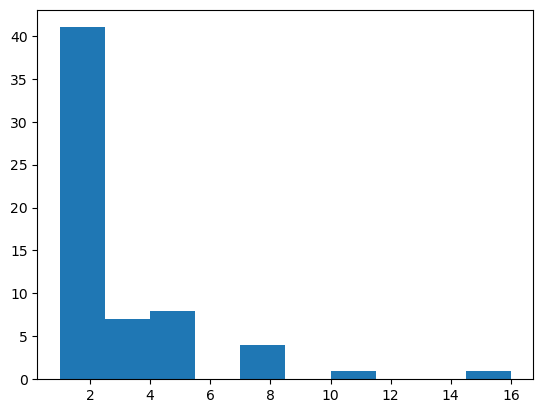

In [23]:
#Визуализируем результат
plt.hist(gdf_coffee_hex_fin.groupby("hex_id")["coffee_count"].sum().to_frame());

In [24]:
#Приступаем к визуализации данных
start_point = gdf_samara_bounds.geometry.unary_union.centroid

C:\Users\acer\AppData\Local\Temp\ipykernel_10992\2966159541.py:2: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  start_point = gdf_samara_bounds.geometry.unary_union.centroid


In [25]:
m = folium.Map([start_point.y,start_point.x], tiles="cartodbpositron", zoom_start=10)

In [26]:
file_name = "gdf_coffee_hex_fin.geojson"
df2geojson = gdf_coffee_hex_fin[["hex_id", "geometry", "coffee_count"]]
df2geojson.to_file(file_name, index=df2geojson.index.tolist(), driver="GeoJSON")

In [27]:
cp = folium.Choropleth(
    geo_data=file_name,
    name="Количество кофеен в каждом гексагоне", 
    data= df2geojson,
    columns=["hex_id", "coffee_count"],
    bins=3, 
    key_on="feature.properties.hex_id",
    fill_color= "OrRd",  #
    fill_opacity=0.7,
    line_opacity=0.1,
    legend_name="Количество кофеен в каждом гексагоне"
).add_to(m)

In [28]:
m

In [29]:
# Инициализируем кластер маркеров
marker_cluster = MarkerCluster(name='Кластеры кофеен').add_to(m)

In [30]:
# Добавляем маркеры в кластер
for idx, row in gdf_coffee.iterrows():
    folium.Marker(
        location=[row["Широта"], row["Долгота"]],
        popup=row.get("Наименование", "Район"),
        icon=folium.Icon(color='blue')
    ).add_to(marker_cluster)

In [31]:
m

In [32]:
heat_data = [[row["Широта"], row["Долгота"]] for idx, row in gdf_coffee.iterrows()]

In [33]:
# Добавляем тепловую карту на карту
HeatMap(heat_data, name='Тепловая карта кофеен').add_to(m)

In [34]:
folium.LayerControl().add_to(m)

In [35]:
m

In [36]:
#Сохраняем получившийся результат
res = "index.html"
m.save(res)